In [1]:
#Import modules
import numpy as np
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns
import time
import pickle
import multiprocessing
import warnings
import parmap
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm
from PIL import Image
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from datetime import datetime
import pickle
import datetime

try:
    import cust_f
except:
    pass
# to perform multiprocessing using a customized function (not necessary for Linux)

tot_run_time_start = time.time()

In [2]:
run_whole_train_fcst_by_arima = False
print('\nForecasting whole train set with ARIMA model <{}>'.format(
    run_whole_train_fcst_by_arima))

run_whole_test_fcst_by_arima = False
print('\nForecasting whole test set with ARIMA model <{}>'.format(
    run_whole_test_fcst_by_arima))

run_new_arima_submission = True
print('\nMake new submission file based on ARIMA <{}>'.format(
    run_new_arima_submission))


Forecasting whole train set with ARIMA model <False>

Forecasting whole test set with ARIMA model <False>

Make new submission file based on ARIMA <True>


In [3]:
warnings.simplefilter('ignore', ConvergenceWarning)
print("\nStatsmodels' ConvergenceWarning is ignored")


Statsmodels' ConvergenceWarning is ignored


In [4]:
np.random.seed(0)  # Fix random seed for making results reproducible

cpu_use = round(multiprocessing.cpu_count() * 3 / 4)

In [6]:
dir_nm_save_fig_eda = 'Fig_dacon_bit_trader_EDA'
try:
    os.mkdir(dir_nm_save_fig_eda)
except FileExistsError:
    pass

dir_nm_save_fig_pred = 'Fig_dacon_bit_trader_prediction'
try:
    os.mkdir(dir_nm_save_fig_pred)
except FileExistsError:
    pass

In [6]:
plt.style.use('default')

mpl.rcParams['axes.unicode_minus'] = False

# Matplotlib fontsize change
SMALL_SIZE = 15
MEDIUM_SIZE = 20
LARGE_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight='bold')
plt.rc('axes', titlesize=LARGE_SIZE, titleweight='bold')
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')
plt.rc('axes', titleweight='bold')
plt.rc('xtick', labelsize=LARGE_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=LARGE_SIZE)

# Save figure settings
high_dpi = 300
fig_file_ext = '.png'
Image.MAX_IMAGE_PIXELS = None  # Ignore DecompressionBombError

In [2]:
with open("../btc_usd_1h.pkl", "rb") as f:
    df = pickle.load(f)
    df.reset_index(drop=True, inplace=True)

In [94]:
df

,Open,High,Low,Close,Volume,Datetime
0,997.75,999.89,996.89,997.69,129.114456,2017-01-02 00:00:00
1,997.69,998.46,997.68,998.46,78.177303,2017-01-02 01:00:00
2,998.46,1005.00,998.44,1005.00,577.409632,2017-01-02 02:00:00
3,1004.99,1005.75,1004.55,1005.75,166.414071,2017-01-02 03:00:00
4,1005.66,1005.73,1003.55,1005.73,148.444520,2017-01-02 04:00:00
...,...,...,...,...,...,...
44347,34954.00,35220.22,34624.59,34799.12,97.552792,2022-01-23 19:00:00
44348,34784.65,35399.02,34736.80,35321.99,61.051839,2022-01-23 20:00:00
44349,35298.00,35579.40,35115.62,35357.49,77.413399,2022-01-23 21:00:00
44350,35340.13,35559.93,35286.52,35530.21,23.553821,2022-01-23 22:00:00


In [ ]:
X_train = df[:1380]
y_train = df[1380:1380 + 120]

142.85714285714286


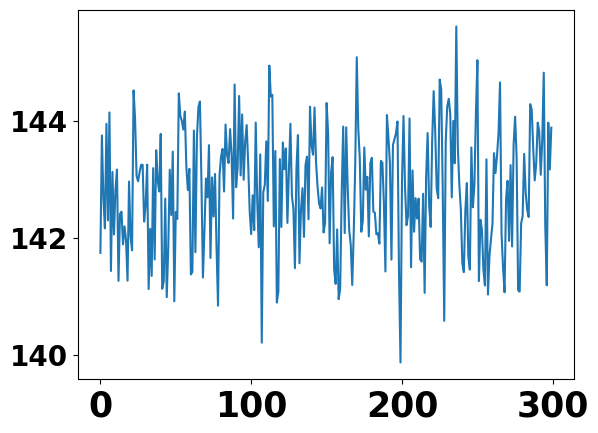

In [6]:
import numpy as np
import matplotlib.pyplot as plt
ar_process = []
y = 140
coff = 0.3
const = 100
for i in range(300):
 error = np.random.randn()
 y = const + y * coff + error
 ar_process.append(y)
print(const / (1 - coff))
plt.plot(ar_process)

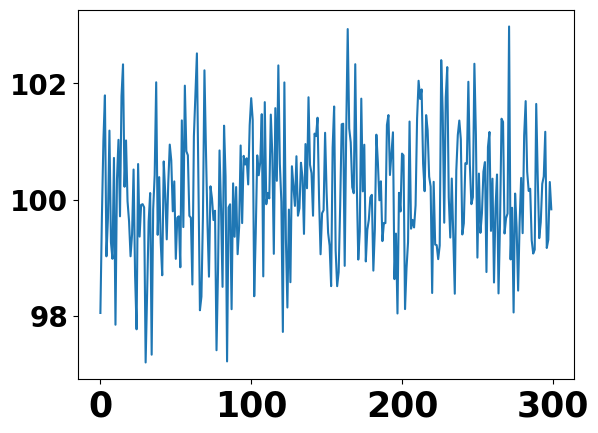

In [7]:
ma_process = []
coff = 0.3
const = 100
error = np.random.randn()
for i in range(300):
 ex_error = error
 error = np.random.randn()
 y = const + coff * ex_error + error
 ma_process.append(y)
plt.plot(ma_process)

In [9]:
def plot_rolling(data, interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()
    #Plot rolling statistics:
    plt.figure(figsize=(20, 6))
    plt.xlabel('Date')
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.show()


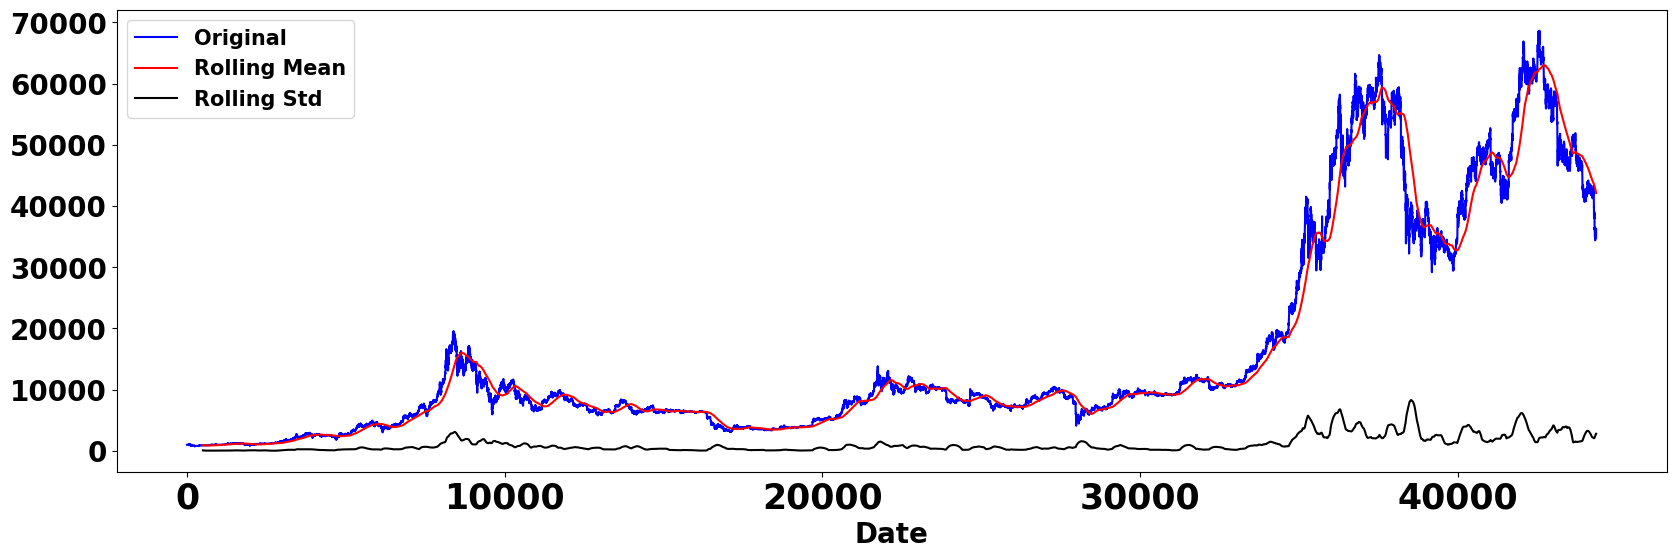

In [10]:
plot_rolling(df['Close'], 500)

In [31]:
df['Close_1d'] = df['Close'] - df['Close'].shift(-1)

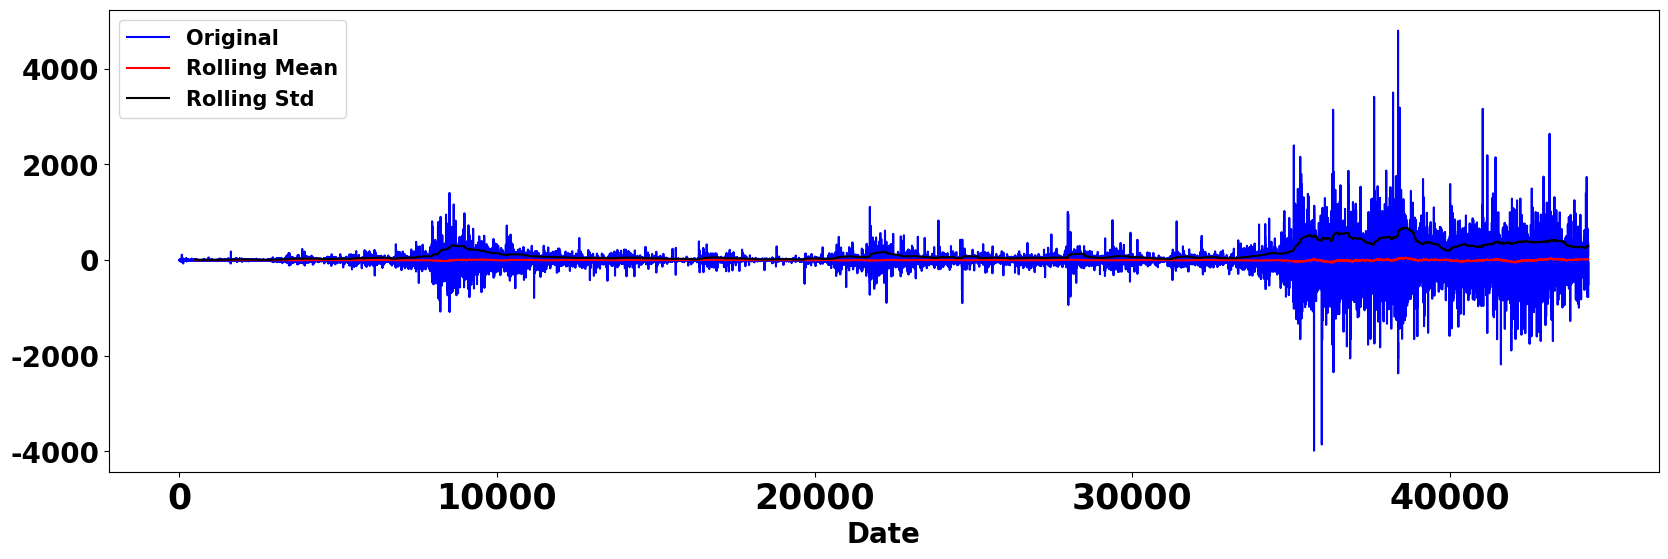

In [32]:
plot_rolling(df['Close_1d'], 500)

In [8]:
y = df['Close']
y_1diff = df['Close'].diff().dropna()
result = adfuller(y)
print(f'원 데이터 ADF Statistic: {result[0]:.3f}')
print(f'원 데이터 p-value: {result[1]:.3f}')
result = adfuller(y_1diff)
print(f'1차 차분 ADF Statistic: {result[0]:.3f}')
print(f'1차 차분 p-value: {result[1]:.3f}')

원 데이터 ADF Statistic: -0.952
원 데이터 p-value: 0.770
1차 차분 ADF Statistic: -28.630
1차 차분 p-value: 0.000


In [43]:
def my_auto_arima(data, order, sort='AIC'):
    order_list = []
    aic_list = []
    bic_list = []

    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p{p} d{d} q{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                     pass

    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [44]:
my_auto_arima(df['Close'], [3,3,3])

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,order,AIC
23,p2 d1 q2,5.959738e+05
22,p2 d1 q1,5.959782e+05
14,p1 d1 q2,5.959785e+05
5,p0 d1 q2,5.959912e+05
25,p2 d2 q1,5.959928e+05
21,p2 d1 q0,5.959932e+05
13,p1 d1 q1,5.959980e+05
26,p2 d2 q2,5.960011e+05
17,p1 d2 q2,5.960028e+05
20,p2 d0 q2,5.960036e+05


In [26]:
model = ARIMA(df['Close'], order=(2,1,2))
model_fit = model.fit()
print(model_fit.summary())
# model_fit.plot_predict()
# plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                44352
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -297981.893
Date:                Mon, 11 Apr 2022   AIC                         595973.785
Time:                        23:02:48   BIC                         596017.285
Sample:                             0   HQIC                        595987.488
                              - 44352                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1358      0.050     -2.728      0.006      -0.233      -0.038
ar.L2          0.3533      0.042      8.336      0.000       0.270       0.436
ma.L1          0.1266      0.049      2.578      0.0

In [28]:
df['result'] = model_fit.fittedvalues

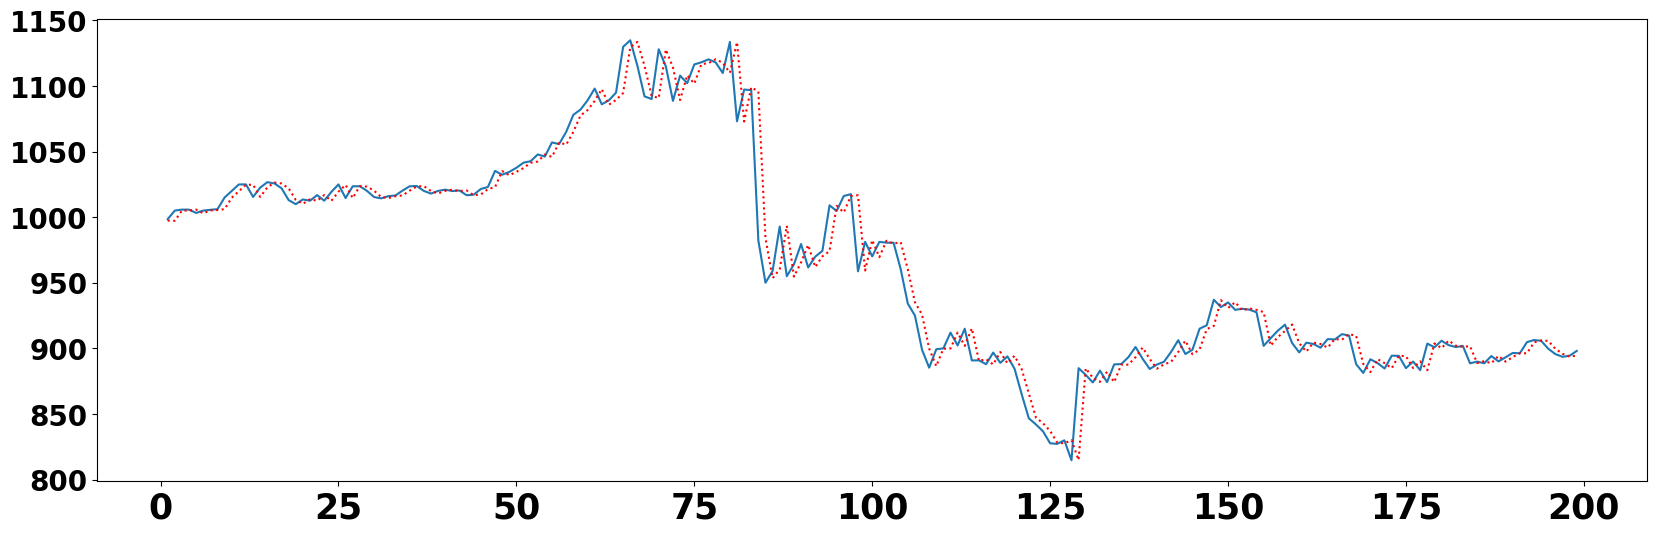

In [35]:
df = df[1:400]
plt.figure(figsize=(20, 6))
plt.plot(df['Close'])
plt.plot(df['result'], color='red', linestyle=":")

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


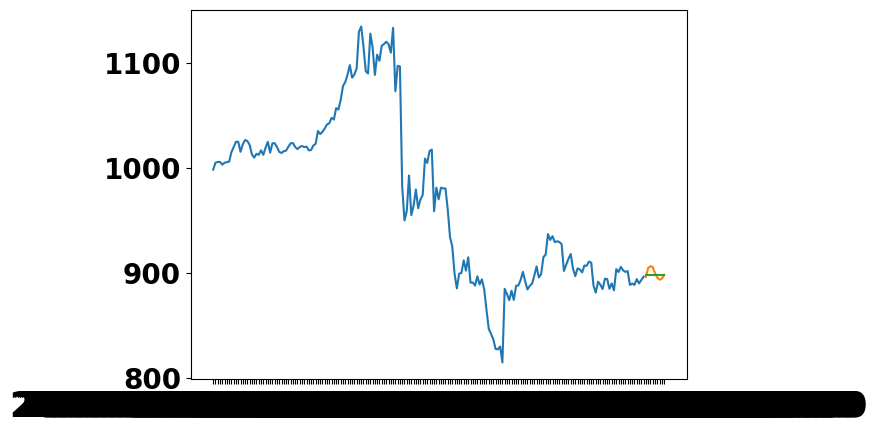

In [91]:
train, test = df[['Close']], df[190:][['Close']]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()
full_forecast = model_fit.forecast(steps=test.shape[0])
forecast = pd.DataFrame(full_forecast[0], index=test.index, columns=test.columns)
plt.plot(df[:190]['Close'])
plt.plot(test)
plt.plot(forecast)

In [95]:
df

,Open,High,Low,Close,Volume,Datetime
0,997.75,999.89,996.89,997.69,129.114456,2017-01-02 00:00:00
1,997.69,998.46,997.68,998.46,78.177303,2017-01-02 01:00:00
2,998.46,1005.00,998.44,1005.00,577.409632,2017-01-02 02:00:00
3,1004.99,1005.75,1004.55,1005.75,166.414071,2017-01-02 03:00:00
4,1005.66,1005.73,1003.55,1005.73,148.444520,2017-01-02 04:00:00
...,...,...,...,...,...,...
44347,34954.00,35220.22,34624.59,34799.12,97.552792,2022-01-23 19:00:00
44348,34784.65,35399.02,34736.80,35321.99,61.051839,2022-01-23 20:00:00
44349,35298.00,35579.40,35115.62,35357.49,77.413399,2022-01-23 21:00:00
44350,35340.13,35559.93,35286.52,35530.21,23.553821,2022-01-23 22:00:00


/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


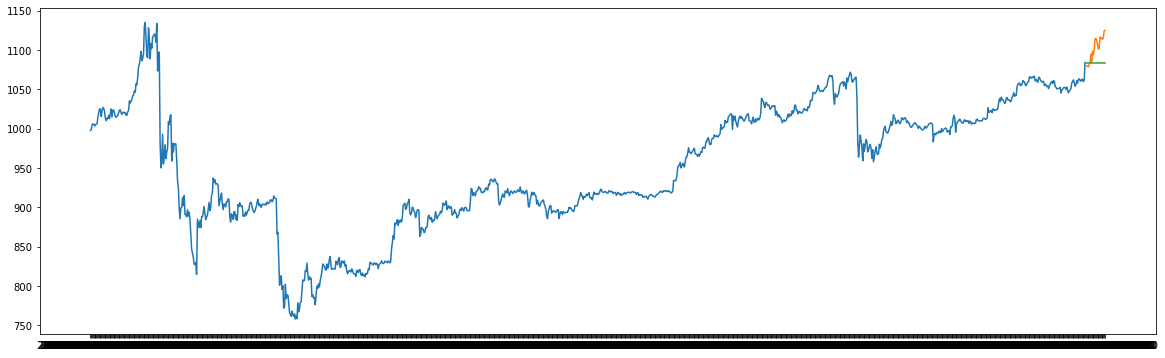

In [7]:
df.index = df.Datetime
plt.figure(figsize=(20, 6))
train, test = df[:1200][['Close']], df[1200:1224][['Close']]
model = ARIMA(train, order=(2,1,2))
model_fit = model.fit()
full_forecast = model_fit.forecast(steps=24)
forecast = pd.DataFrame(full_forecast[0], index=test.index, columns=test.columns)
plt.plot(df[:1200]['Close'])
plt.plot(test)
plt.plot(forecast)

In [11]:
idx = 0
start_idx = 1200
end_idx = start_idx + 24
result_list = []

while (start_idx < 1400):
    train, test = df[:start_idx][['Close']], df[start_idx:end_idx][['Close']]
    model = ARIMA(train, order=(2,1,2))
    model_fit = model.fit()
    full_forecast = model_fit.forecast(steps=24)
    start_idx += 24
    end_idx += 24
    for _ in range(24):
        result_list.append(full_forecast[0])

/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/capstone/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency i

In [12]:
result_list

[1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1083.661418187275,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1124.696773148827,
 1130.7819534451241,
 1130.7819534451241